A notebook to explore how well astrometry performs on a single night. Check the RMS of object centroid as a function of SNR.

The theory here is that one can fit proper motion and parallax (and possibly differential refraction) with minimal covariance. Thus we can use simple error propigation to compute the unctertainty on a fit of that only has motion due to proper motion, and a star that only has parallax motion.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from lsst.daf.persistence import Butler
from lsst.afw.table import MultiMatch
from lsst.afw.image import abMagFromFlux, fluxFromABMag

In [3]:
# Handy function for later. 
# Stolen from lsst.sims.maf.utils. Should probably go to a more general library.
def gnomonic_project_toxy(RA1, Dec1, RAcen, Deccen):
    """
    Calculate the x/y values of RA1/Dec1 in a gnomonic projection with center at RAcen/Deccen.

    Parameters
    ----------
    RA1 : numpy.ndarray
        RA values of the data to be projected, in radians.
    Dec1 : numpy.ndarray
        Dec values of the data to be projected, in radians.
    RAcen: float
        RA value of the center of the projection, in radians.
    Deccen : float
        Dec value of the center of the projection, in radians.

    Returns
    -------
    numpy.ndarray, numpy.ndarray
        The x/y values of the projected RA1/Dec1 positions.
    """
    cosc = np.sin(Deccen) * np.sin(Dec1) + np.cos(Deccen) * np.cos(Dec1) * np.cos(RA1-RAcen)
    x = np.cos(Dec1) * np.sin(RA1-RAcen) / cosc
    y = (np.cos(Deccen)*np.sin(Dec1) - np.sin(Deccen)*np.cos(Dec1)*np.cos(RA1-RAcen)) / cosc
    return x, y


In [4]:
# set up a butler
butler = Butler('/project/shared/data/Twinkles_subset/output_data_v2')

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
# This is pulling the initial pipeline WCS fit. In the future, will want to use jointcal results.
# Could imagine looping over different filters.
subset = butler.subset('src', filter='r')

In [6]:
# Copy pasta from matching notebook. Presumably, using jointcal would already have things matched up
matched_cat = None
calexps = {}
for data_ref in subset:
    data_id = data_ref.dataId
    src_cat = data_ref.get('src')
    calexps[data_id['visit']] = data_ref.get('calexp')
    if matched_cat is None:
        id_fmt = {'visit':np.int64}
        # Using default 0.5 arcsec radius
        matched_cat = MultiMatch(src_cat.schema, id_fmt)
    matched_cat.add(src_cat, data_id)
final_catalog = matched_cat.finish()

In [7]:
# Find the unique object IDs
object_ids = final_catalog.get('object')
unique_object_ids = np.unique(object_ids)

In [8]:
unique_object_ids

array([   1,    2,    3, ..., 6696, 6697, 6698], dtype=int64)

In [9]:
# For each unique object, want to know the

In [10]:
final_catalog

<class 'lsst.afw.table.source.source.SourceCatalog'>
      id           coord_ra           coord_dec       ... object visit
                     rad                 rad          ...             
------------- ------------------ -------------------- ... ------ -----
 988882665473 0.9235074520228211  -0.4766365244228648 ...      1   230
 988882665474  0.923440817814142 -0.47691936249744354 ...      2   230
 988882665475 0.9234075343436854  -0.4770033201661779 ...      3   230
 988882665476 0.9227891880394103 -0.47936484621963726 ...      4   230
 988882665477 0.9227211251615833  -0.4796207587219972 ...      5   230
 988882665478 0.9226835125005866  -0.4797644474181495 ...      6   230
 988882665479 0.9231775946204576 -0.47789024798034624 ...      7   230
1001767567613 0.9231778259833596  -0.4778902460626018 ...      7   233
1010357502194 0.9231776163406615 -0.47789030940973437 ...      7   235
1023242404072 0.9231782648808977 -0.47789014784112605 ...      7   238
          ...           

In [11]:
# array to hold stats for each object we have matched up
names = ['id', 'flux_avg', 'flux_std', 'flux_err_avg',
         'mag', 'snr_avg', 'ra_rms_arcsec', 'dec_rms_arcsec']
dtypes = [int, float, float, float, float, float, float, float]
results = np.zeros(len(unique_object_ids), dtype=list(zip(names, dtypes)))

In [12]:
final_catalog.get('base_PsfFlux_fluxSigma')

array([258.14268182, 315.25233253, 247.05316257, ..., 261.09860621,
       536.96358889, 260.61019959])

In [13]:
for i,obj_id in enumerate(unique_object_ids):
    idx = np.where(final_catalog.get('object')==obj_id)[0]
    # only ones where we have enough observations to do stats
    if np.size(idx) > 4:
        # pull out the ra and dec (these are in radians)
        ra = final_catalog.get('coord_ra')[idx]
        dec = final_catalog.get('coord_dec')[idx]
        x,y = gnomonic_project_toxy(ra, dec, ra[0], dec[0])
        results['id'][i] = obj_id
        results['ra_rms_arcsec'][i] = np.std(np.degrees(x)*3600.)
        results['dec_rms_arcsec'][i] = np.std(np.degrees(y)*3600.)
        # Now to get the fluxes
        flux_inst = final_catalog.get('base_PsfFlux_flux')[idx]
        flux_inst_err = final_catalog.get('base_PsfFlux_fluxSigma')[idx]
        flag_gen = final_catalog.get('base_PsfFlux_flag')[idx]
        flag_edge = final_catalog.get('base_PsfFlux_flag_edge')[idx]
        flag_nogood = final_catalog.get('base_PsfFlux_flag_noGoodPixels')[idx]
        visit = final_catalog.get('visit')[idx]
        flux = []
        flux_err = []
        for f, f_err, v, fl1, fl2, fl3 in zip(flux_inst, flux_inst_err, visit, flag_gen, flag_edge, flag_nogood):
            if f > 0. and not (fl1|fl2|fl3):
                calib = calexps[v].getCalib()
                flux.append(fluxFromABMag(calib.getMagnitude(f)))
                flux_err.append(fluxFromABMag(calib.getMagnitude(f_err)))
        flux = np.array(flux)
        flux_err = np.array(flux_err)
        # might want to put some weights on these things
        results['flux_avg'][i] = np.average(flux)
        results['mag'][i] = abMagFromFlux(results['flux_avg'][i])
        results['flux_std'][i] = np.std(flux)
        results['flux_err_avg'] = np.average(flux_err)
        results['snr_avg'][i] = np.average(flux/flux_err)
        
# crop off the rows we skipped
results = results[np.where(results['id'] != 0)]

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


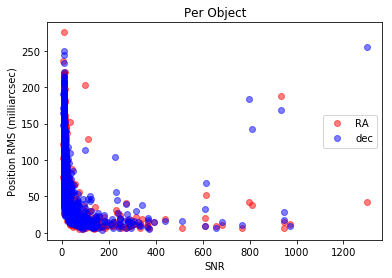

In [14]:
plt.plot(results['snr_avg'], results['ra_rms_arcsec']*1e3, 'ro', alpha=.5, label='RA')
plt.plot(results['snr_avg'], results['dec_rms_arcsec']*1e3, 'bo', alpha=.5, label='dec')
plt.xlabel('SNR')
plt.ylabel('Position RMS (milliarcsec)')
plt.title('Per Object')
plt.legend()

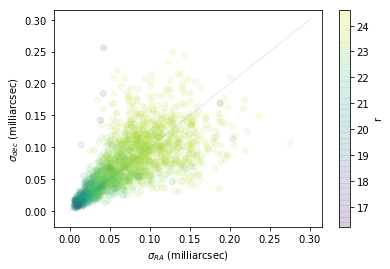

In [15]:
plt.scatter(results['ra_rms_arcsec'], results['dec_rms_arcsec'], c=results['mag'], alpha=.1)
plt.plot([0,.3], [0,.3], alpha=.1)
plt.xlabel(r'$\sigma_{RA}$ (milliarcsec)')
plt.ylabel(r'$\sigma_{dec}$ (milliarcsec)')
cb = plt.colorbar()
cb.set_label('r')

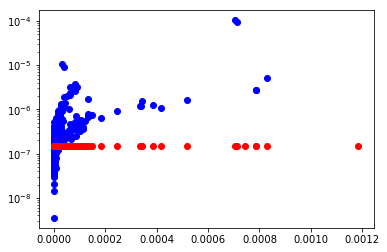

In [16]:
# I don't think I understand this plot.
plt.semilogy(results['flux_avg'], results['flux_std'], 'bo')
plt.plot(results['flux_avg'], results['flux_err_avg'], 'ro')

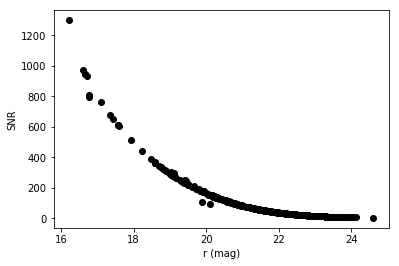

In [17]:
plt.plot(results['mag'], results['snr_avg'], 'ko')
plt.xlabel('r (mag)')
plt.ylabel('SNR')

In [31]:
# OK, let's say we want to know the final proper motion precision for a r=20 star
mag_check = 23.
mag_width = 0.1
inbin = np.where((results['mag'] > mag_check-mag_width) & (results['mag'] <  mag_check+mag_width))
snr = np.median(results['snr_avg'][inbin])
position_err = np.median(results['dec_rms_arcsec'][inbin]) # arcsec


In [32]:
# from lsst.sims.maf.utils. 
# For justification for simplified astromertic error propigation, see:
# https://github.com/yoachim/18_scratch/tree/master/astrom_exmaple
# Which should be put into a tech note
def sigma_slope(x, sigma_y):
    """
    Calculate the uncertainty in fitting a line, as
    given by the spread in x values and the uncertainties
    in the y values.

    Parameters
    ----------
    x : numpy.ndarray
        The x values of the data
    sigma_y : numpy.ndarray
        The uncertainty in the y values

    Returns
    -------
    float
        The uncertainty in the line fit
    """
    w = 1./sigma_y**2
    denom = np.sum(w)*np.sum(w*x**2)-np.sum(w*x)**2
    if denom <= 0:
        return np.nan
    else:
        result = np.sqrt(np.sum(w)/denom )
        return result

In [33]:
# observe every 8 days for 10 years. 
# Could plug in a sequence from OpSim or something else.
mjd0 = 60000.
mjds = np.arange(mjd0,mjd0+3652, 8)
observation_dates = mjds/365.25 # years

In [34]:
pm_uncert = sigma_slope(observation_dates, observation_dates*0+position_err/1e-3) # result in milliarcsec/yr

In [35]:
print('Proper motion uncertainty in %.1f mag star, observed %i times over %.1f years = %.2f marcsec/year' % (mag_check, np.size(observation_dates), np.max(observation_dates)-np.min(observation_dates), pm_uncert))

Proper motion uncertainty in 23.0 mag star, observed 457 times over 10.0 years = 0.99 marcsec/year


In [36]:
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord

In [37]:
# OK, let's pretend we get astrometry this good at some spot in the sky
ra = 0.*u.deg
dec = 45.*u.deg
star_fixed = SkyCoord(ra, dec, frame='icrs')#, distance=1.1*u.pc)
star_near = SkyCoord(ra, dec, frame='icrs', distance=1.*u.pc)
# Compute the parallax factor for each MJD
delta_ra = np.zeros(observation_dates.size, dtype=float)
delta_dec = np.zeros(observation_dates.size, dtype=float)
t = Time(observation_dates[10], format='mjd')

In [38]:
for i,mjd in enumerate(mjds):
    t = Time(mjd, format='mjd')
    star_near.obstime=t
    star_fixed.obstime=t
    fixed_gcrs = star_fixed.gcrs
    near_gcrs = star_near.gcrs
    x,y = gnomonic_project_toxy(near_gcrs.ra.to(u.rad), near_gcrs.dec.to(u.rad),
                               fixed_gcrs.ra.to(u.rad), fixed_gcrs.dec.to(u.rad))
    delta_ra[i] = x
    delta_dec[i] = y

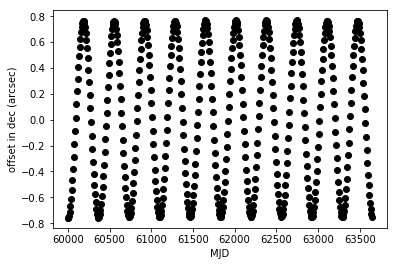

In [39]:
# Let's check that astropy did indeed work properly
plt.plot(mjds, np.degrees(delta_dec)*3600, 'ko')
plt.xlabel('MJD')
plt.ylabel('offset in dec (arcsec)')

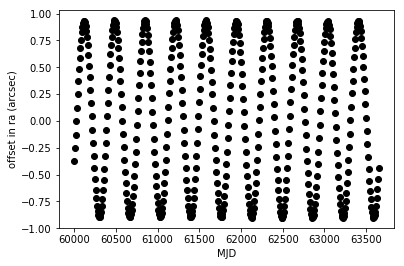

In [40]:
plt.plot(mjds, np.degrees(delta_ra)*3600, 'ko')
plt.xlabel('MJD')
plt.ylabel('offset in ra (arcsec)')

In [41]:
# If we have enough points, we can assume the central position and proper motion have been fit and removed. 
pi_ra_uncert = position_err/(np.degrees(delta_ra)*3600)
pi_dec_uncert = position_err/(np.degrees(delta_dec)*3600)

sigma_ra = np.sqrt(1./np.sum((1./(pi_ra_uncert**2))))
sigma_dec = np.sqrt(1./np.sum((1./pi_dec_uncert**2)))

sigma_final = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))

In [42]:
print('A %.1f mag star would have a final parallax precision of %.2f mas' % (mag_check, sigma_final*1e3))

A 23.0 mag star would have a final parallax precision of 3.41 mas


In [43]:
# sanity check, should be a little bit smaller than the above value because not all observations 
# actually contribute much to the parallax determination (unless you are at ecliptic poles)
print(position_err/np.sqrt(mjds.size)*1e3)

2.873299895723764
